NOTE: I only picked the "most interesting" plots to include in the report. However, in my code I have many more
Therefore you might see plots here that weren't included!
STUDENT ID: 14121917

### EDA

#### Completeness of Data

In [605]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [607]:
df = pd.read_csv("MavenRail.csv")
num_records = df.shape[0]
print(f"Number of Records: {num_records}")

Number of Records: 31645


In [609]:
def attributeCol(Column):
    print(f"{Column} Missing Values", df[Column].isna().sum())
for i in df.columns:
    attributeCol(i)

Payment.Method Missing Values 0
Railcard Missing Values 20911
Ticket.Class Missing Values 0
Ticket.Type Missing Values 0
Price Missing Values 0
Departure.Station Missing Values 0
Arrival.Station Missing Values 0
Departure Missing Values 3
Scheduled.Arrival Missing Values 4
Actual.Arrival Missing Values 1880
Journey.Status Missing Values 0
Reason.for.Delay Missing Values 27479
Refund.Request Missing Values 0
Row_ID Missing Values 0


In [611]:
missing_departure_station = df[df['Departure'].isna()]
print("Here are the rows where the Departure is missing:")
print(missing_departure_station)

Here are the rows where the Departure is missing:
      Payment.Method  Railcard Ticket.Class Ticket.Type  Price  \
23613    Credit Card       NaN  First Class     Advance     10   
23614    Contactless  Disabled     Standard    Off-Peak      3   
23618    Contactless       NaN     Standard    Off-Peak     11   

           Departure.Station        Arrival.Station Departure  \
23613  Liverpool Lime Street  Manchester Piccadilly       NaN   
23614  Liverpool Lime Street  Manchester Piccadilly       NaN   
23618                   York                 Durham       NaN   

      Scheduled.Arrival    Actual.Arrival Journey.Status Reason.for.Delay  \
23613               NaN               NaN        On Time              NaN   
23614  2024-03-31 02:00  2024-03-31 02:00        On Time              NaN   
23618  2024-03-31 02:35  2024-03-31 02:35        On Time              NaN   

      Refund.Request  Row_ID  
23613             No   23614  
23614             No   23615  
23618             No  

#### Filling Missing Values:

Starting by the datetime columns (Departure, Scheduled Arrival) We can notice 2 of the 3 missing records for Departure hvae the same route,
One of the two records will be dropped as we have no information about Departure, Scheduled Arrival or Actual Arrival therefore it will not be possible to estimate this record.
The second record however, has a Scheduled Arrival and we can see from Journey.Status it was on time.
I will search for other records with same route, and see how much it takes and then fill the Departure by deducting the Scheduled Arrival minus the value calculated.

In [615]:
# Firstly I will be assigning indexes to records so that I can handle them easier
df['Row_ID'] = range(1,len(df)+1)
df.to_csv('MavenRail.csv',index=False)

In [617]:
# Dropping the first record
df = df[df['Row_ID'] != 23614]

In [619]:
# Calculating Journey Time for Liverpool - Manchester in other records to fill the second missing record
df['Departure'] = pd.to_datetime(df['Departure'])
df['Scheduled.Arrival'] = pd.to_datetime(df['Scheduled.Arrival'])
filtered_stations = df[(df['Departure.Station'] == 'Liverpool Lime Street') & (df['Arrival.Station'] == 'Manchester Piccadilly') 
                    & (df['Journey.Status'] == 'On Time')]
print(filtered_stations['Scheduled.Arrival'] - filtered_stations['Departure'])

2       0 days 00:30:00
7       0 days 00:30:00
21      0 days 00:30:00
38      0 days 00:30:00
41      0 days 00:30:00
              ...      
31578   0 days 00:30:00
31594   0 days 00:30:00
31609   0 days 00:30:00
31632   0 days 00:30:00
31644   0 days 00:30:00
Length: 2770, dtype: timedelta64[ns]


In [621]:
from datetime import timedelta
# Now we know it is 30 minutes, we add it to the missing record
df.loc[df['Row_ID']==23615,'Departure'] = df.loc[df['Row_ID'] == 23615, 'Scheduled.Arrival'] - timedelta(minutes=30)
df.to_csv('MavenRailModified.csv',index=False)

In [622]:
# Calculation of time for the 3rd departure record missing
filtered = df[(df['Departure.Station'] == 'York') & (df['Arrival.Station'] == 'Durham') 
                    & (df['Journey.Status'] == 'On Time')]
print(filtered['Scheduled.Arrival']- filtered['Departure'])

10        0 days 00:50:00
87        0 days 00:50:00
89        0 days 00:50:00
95      -1 days +00:50:00
97      -1 days +00:50:00
               ...       
31247     0 days 00:50:00
31248     0 days 00:50:00
31255   -1 days +00:50:00
31256   -1 days +00:50:00
31273     0 days 00:50:00
Length: 225, dtype: timedelta64[ns]


In [625]:
df.loc[df['Row_ID']==23619,'Departure'] = df.loc[df['Row_ID'] == 23619, 'Scheduled.Arrival'] - timedelta(minutes=50)
df.to_csv('MavenRailModified.csv',index=False)

In [627]:
# Now we check the Scheduled Arrival missing
missing_arrival = df[df['Scheduled.Arrival'].isna()]
print(missing_arrival)

      Payment.Method Railcard Ticket.Class Ticket.Type  Price  \
23609    Credit Card      NaN     Standard     Advance     37   
23616    Contactless    Adult     Standard    Off-Peak     24   
23624    Credit Card      NaN     Standard    Off-Peak    113   

           Departure.Station Arrival.Station           Departure  \
23609          London Euston            York 2024-03-31 00:00:00   
23616                   York       Edinburgh 2024-03-31 22:30:00   
23624  Liverpool Lime Street   London Euston 2024-03-31 23:30:00   

      Scheduled.Arrival    Actual.Arrival Journey.Status Reason.for.Delay  \
23609               NaT  2024-03-31 02:46        Delayed   Signal Failure   
23616               NaT               NaN        On Time              NaN   
23624               NaT               NaN        On Time              NaN   

      Refund.Request  Row_ID  
23609             No   23610  
23616             No   23617  
23624             No   23625  


In [629]:
# Since this route, all of its records have signal failure, this missing values one wont be informative
df = df[df['Row_ID'] != 23610]

In [631]:
# I calculcate duration from scheduled arrival - departure to hot deck impute
filtered_stations = df[(df['Departure.Station'] == 'York') & (df['Arrival.Station'] == 'Edinburgh') 
                    & (df['Journey.Status'] == 'On Time')]
print(filtered_stations['Scheduled.Arrival'] - filtered_stations['Departure'])

222       0 days 02:30:00
241       0 days 02:30:00
269       0 days 02:30:00
516       0 days 02:30:00
637     -1 days +02:30:00
               ...       
31230     0 days 02:30:00
31330     0 days 02:30:00
31332     0 days 02:30:00
31363     0 days 02:30:00
31378     0 days 02:30:00
Length: 134, dtype: timedelta64[ns]


In [633]:
# I calculcate duration from scheduled arrival - departure to hot deck impute
filtered_stations = df[(df['Departure.Station'] == 'Liverpool Lime Street') & (df['Arrival.Station'] == 'London Euston') 
                    & (df['Journey.Status'] == 'On Time')]
print(filtered_stations['Scheduled.Arrival'] - filtered_stations['Departure'])

4         0 days 02:15:00
68        0 days 02:15:00
150       0 days 02:15:00
157       0 days 02:15:00
645     -1 days +02:15:00
               ...       
31252   -1 days +02:15:00
31295     0 days 02:15:00
31401     0 days 02:15:00
31543     0 days 02:15:00
31618     0 days 02:15:00
Length: 218, dtype: timedelta64[ns]


In [635]:
# Add the missing values depending on hot deck impute
df.loc[df['Row_ID']==23617,'Scheduled.Arrival'] = df.loc[df['Row_ID'] == 23617, 'Departure'] + timedelta(hours=2,minutes=30)
df.loc[df['Row_ID']==23625,'Scheduled.Arrival'] = df.loc[df['Row_ID'] == 23625, 'Departure'] + timedelta(hours=2,minutes=15)

df.to_csv('MavenRailModified.csv',index=False)

Above: I add the missing values depending on similar routes. (hot-deck imputation)

### Univariate

##### Table like information

In [2258]:
# Table like information for all univariates
import seaborn as sns
Payment_Dist= df['Payment.Method'].value_counts()
print(Payment_Dist)

df['Railcard'] = df['Railcard'].fillna('None')
Railcard_Dist = df['Railcard'].value_counts()
print(Railcard_Dist)

Ticket_Dist = df['Ticket.Class'].value_counts()
print(Ticket_Dist)

Ticket_Type_Dist = df['Ticket.Type'].value_counts()
print(Ticket_Type_Dist)

Journey_Status_Dist= df['Journey.Status'].value_counts()
print(Journey_Status_Dist)

df['Reason.for.Delay'] = df['Reason.for.Delay'].replace({'Staffing' : 'Staff-Related', 'Staff' : 'Staff-Related'})
Reason4Delay_Dist = df['Reason.for.Delay'].value_counts()
print(Reason4Delay_Dist)
print("All Delays: ",Reason4Delay_Dist.sum())
df.to_csv("MavenRailModified.csv",index=False)

Payment.Method
Credit Card    19131
Contactless    10831
Debit Card      1680
Name: count, dtype: int64
Railcard
None        20908
Adult        4845
Disabled     3089
Senior       2800
Name: count, dtype: int64
Ticket.Class
Standard       28586
First Class     3056
Name: count, dtype: int64
Ticket.Type
Advance     17555
Off-Peak     8747
Anytime      5340
Name: count, dtype: int64
Journey.Status
On Time      27477
Delayed       2288
Cancelled     1877
Name: count, dtype: int64
Reason.for.Delay
Weather            1372
Signal Failure      967
Staff-Related       806
Technical Issue     706
Traffic             314
Name: count, dtype: int64
All Delays:  4165


/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/3069211099.py:21: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x='Ticket.Class', data=df,hue='Ticket.Class', palette=colors, ax=axes[1, 0])


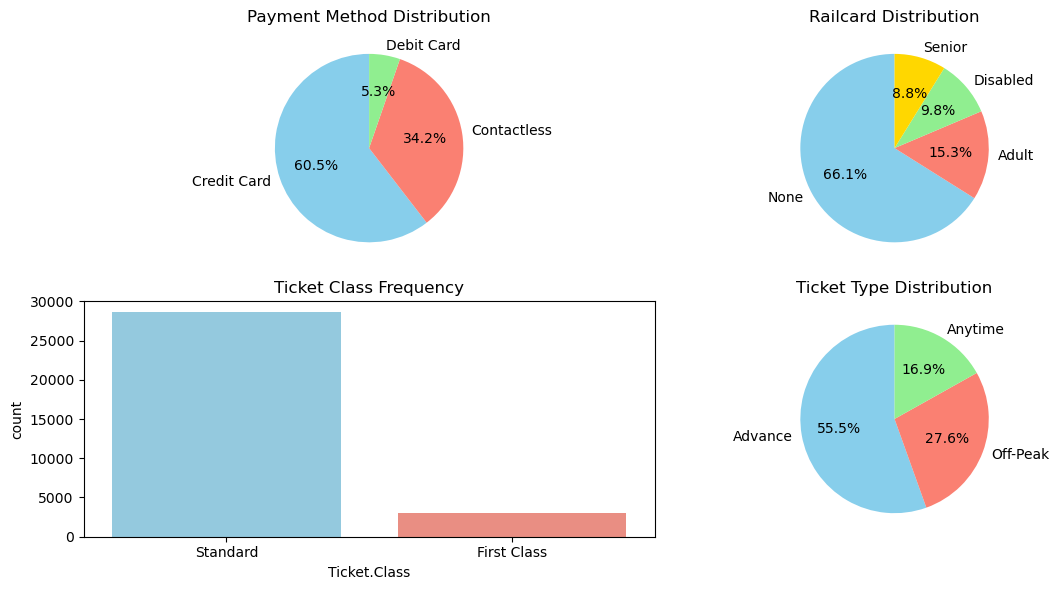

In [642]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'orange']  

# creating a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  

# PAYMENT
axes[0, 0].pie(Payment_Dist, labels=Payment_Dist.index, colors=colors,
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Payment Method Distribution')

# RAILCARD
axes[0, 1].pie(Railcard_Dist, labels=Railcard_Dist.index, colors=colors,
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Railcard Distribution')

# TICKET (using countplot)
sns.countplot(x='Ticket.Class', data=df,hue='Ticket.Class', palette=colors, ax=axes[1, 0])
axes[1, 0].set_title('Ticket Class Frequency')

# TYPE
axes[1, 1].pie(Ticket_Type_Dist, labels=Ticket_Type_Dist.index, colors=colors,
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Ticket Type Distribution')
plt.tight_layout()
plt.show()


#### Price Distribution

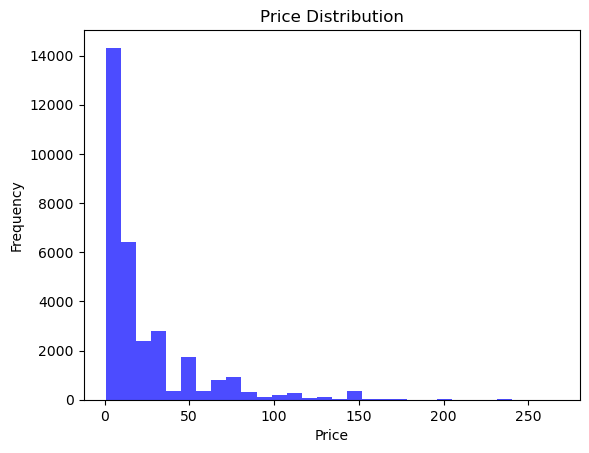

In [645]:
# Histogram for price distribution
df['Price'].plot(kind='hist', bins=30, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [647]:
# Statistics
print(df['Price'].describe())

count    31643.000000
mean        23.434630
std         29.991135
min          1.000000
25%          5.000000
50%         11.000000
75%         35.000000
max        267.000000
Name: Price, dtype: float64


It is observable that the Price distribution is right skewed where most of the ticket prices were concentrated within the 0-30 (GPB) range, In addition, the disparity between the max(267 GPB) and mean (23.43 GPB) supports the observation about skewness.
In such case, using the median for price analysis, for example, "Comparing ticket pricess based on ticket types" would be much more representative since the median is more stable and is not affected/influenced by the outliers the way the mean is.

#### Payment Method Distribution

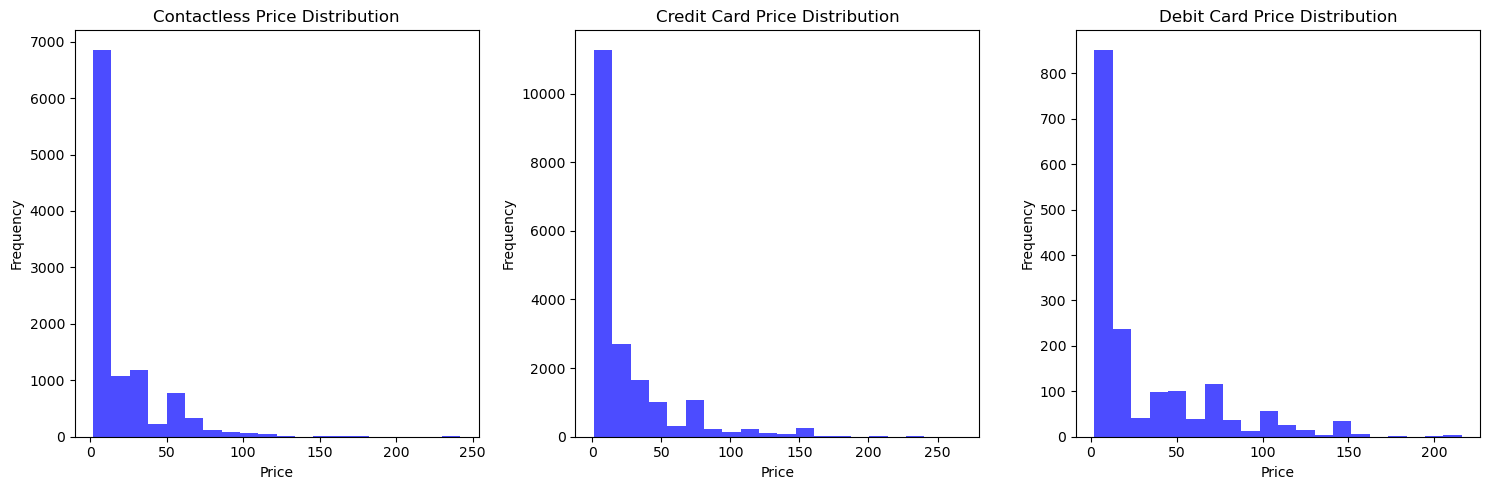

In [651]:
import matplotlib.pyplot as plt

# grouping the data by 'Payment.Method' and plot separate histograms for each group
payment_methods = df['Payment.Method'].unique()

# figure for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# plotting the histograms on axis
for i, payment_method in enumerate(payment_methods):
    # flitering the dataframe for each payment method
    payment_data = df[df['Payment.Method'] == payment_method]
    
    axes[i].hist(payment_data['Price'], bins=20, color='blue', alpha=0.7)
    axes[i].set_title(f'{payment_method} Price Distribution')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


CAN SEE SKEWNESS -> LINK THIS WHY I CHOSE MEDIAN IN WITH MULTIVARIATE OF PAYMENT METHOD WITH REFUND REQUEST 
(CAN SEE THAT IN DEBIT CARD ALMOST 50% ARE REQUESTING REFUND EVEN THOUGH MEDIAN IS ALMOST SAME MEANING THEY HAVE SAME RANGE OF PRICES)

#### Departure Frequency

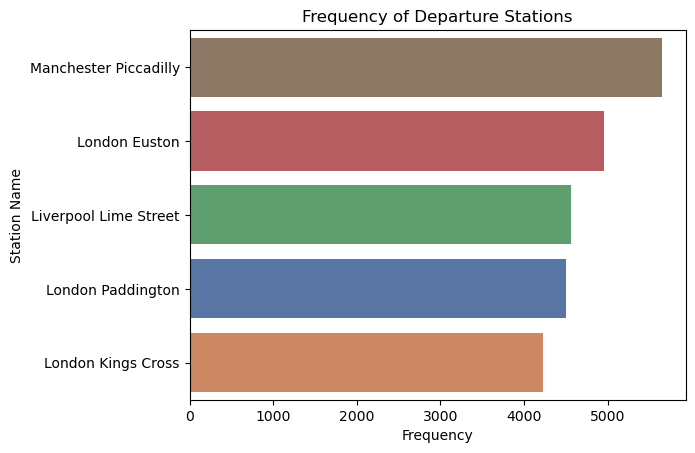

In [2260]:
# Count plot for departure frequency, frequency on the X axis and Station name on Y.
sns.countplot(y="Departure.Station", data=df,order=df['Departure.Station'].value_counts().head(5).index,hue="Departure.Station",palette='deep')
plt.title("Frequency of Departure Stations")
plt.xlabel("Frequency")
plt.ylabel("Station Name")
plt.show()

#### Arrival Frequency

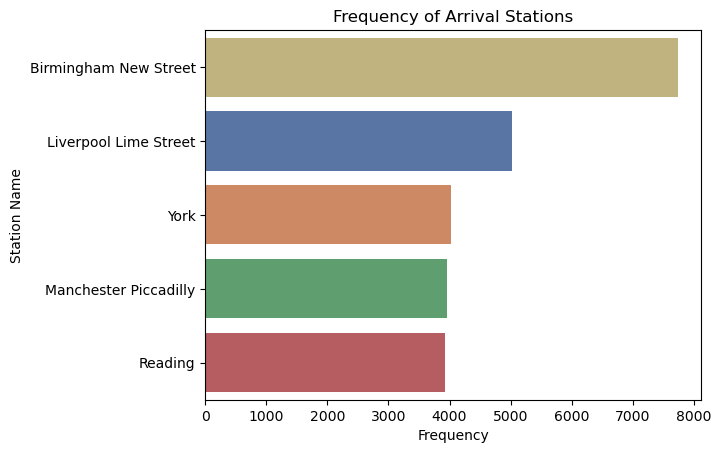

In [2248]:
# Similar as before but for Arrival stations
sns.countplot(y="Arrival.Station", data=df,order=df['Arrival.Station'].value_counts().head(5).index,hue="Arrival.Station",palette='deep')
plt.title("Frequency of Arrival Stations")
plt.xlabel("Frequency")
plt.ylabel("Station Name")
plt.show()

#### Departure Time Distribution

/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/42206937.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Departure'].dt.hour, shade=True, color='blue')


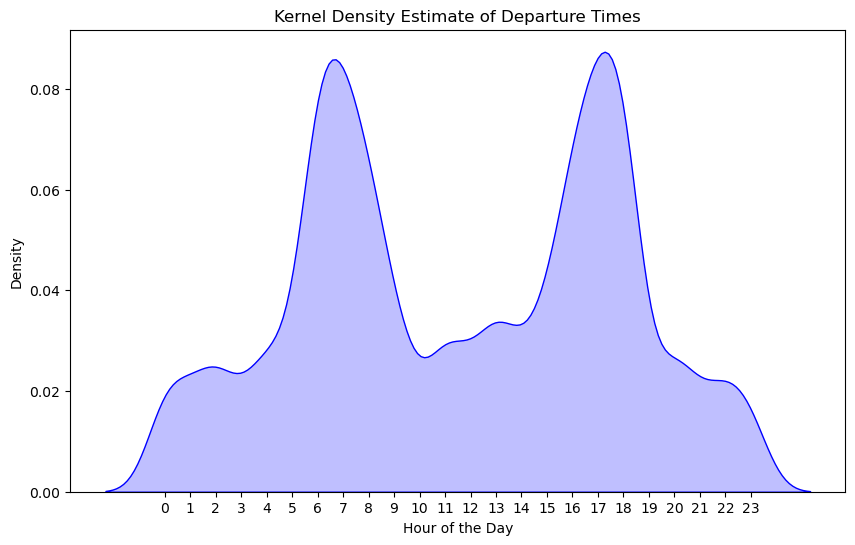

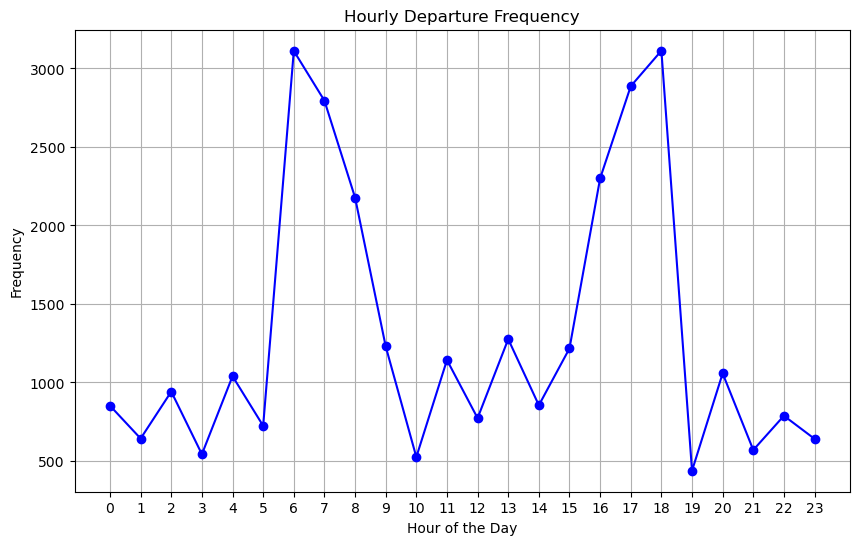

In [661]:
#KDE for departure times
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Departure'].dt.hour, shade=True, color='blue')
plt.title('Kernel Density Estimate of Departure Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.xticks(range(0, 24))
plt.show()
# FREQ of departures per hour
time_counts = df.groupby(df['Departure'].dt.hour).size()
plt.figure(figsize=(10, 6))
time_counts.plot(kind='line', marker='o', color='blue')
plt.title('Hourly Departure Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/1149869636.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Scheduled.Arrival'].dt.hour, shade=True, color='blue')


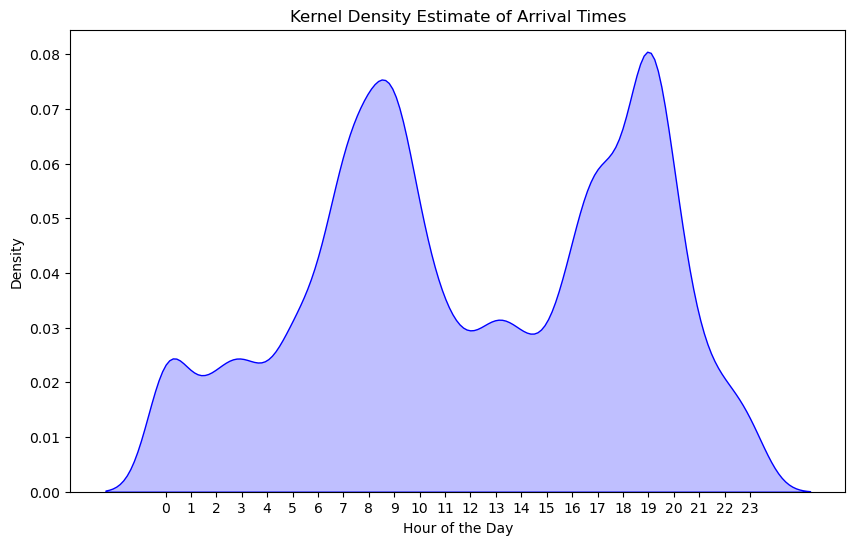

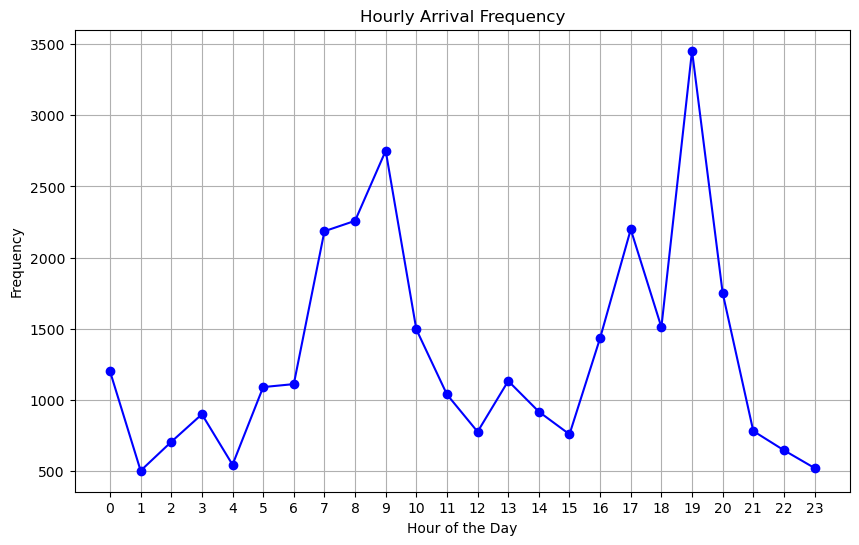

In [662]:
#KDE for arrival hours
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Scheduled.Arrival'].dt.hour, shade=True, color='blue')
plt.title('Kernel Density Estimate of Arrival Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.xticks(range(0, 24))
plt.show()
# FREQ of arrivals per hour
time_counts = df.groupby(df['Scheduled.Arrival'].dt.hour).size()
plt.figure(figsize=(10, 6))
time_counts.plot(kind='line', marker='o', color='blue')
plt.title('Hourly Arrival Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

#### Journey Status

Text(0.5, 1.0, 'Journey Status Distribution')

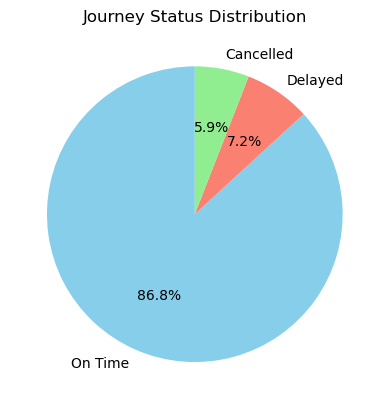

In [665]:
# pie chart for journey status
journeycolors = ['skyblue','salmon','lightgreen']
plt.pie(Journey_Status_Dist,labels=Journey_Status_Dist.index,colors=journeycolors,autopct='%1.1f%%', startangle=90)
plt.title("Journey Status Distribution")

#### Reasons For Delay

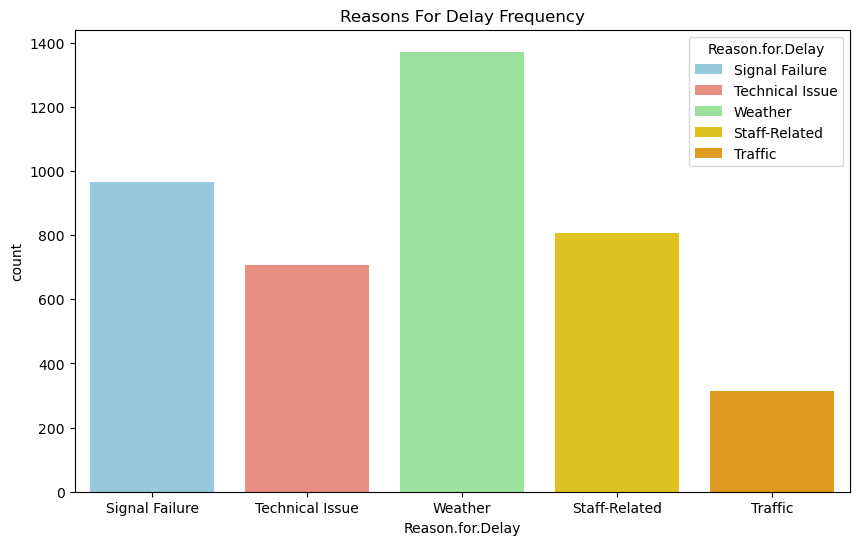

In [669]:
# count plot for reason for delay occurences.
plt.figure(figsize=(10,6))
sns.countplot(x='Reason.for.Delay', data=df,hue='Reason.for.Delay', palette=colors)
plt.title("Reasons For Delay Frequency")
plt.show()

### Multivariate

#### Cross table for Journey Status and Refund Requests

In [673]:
# Cross table for journey status and refund requests
df1 = pd.read_csv("MavenRailModified.csv")
crosstab_analysis = pd.crosstab(df1['Journey.Status'], df1['Refund.Request'])
print(crosstab_analysis)

Refund.Request     No  Yes
Journey.Status            
Cancelled        1307  570
Delayed          1744  544
On Time         27478    0


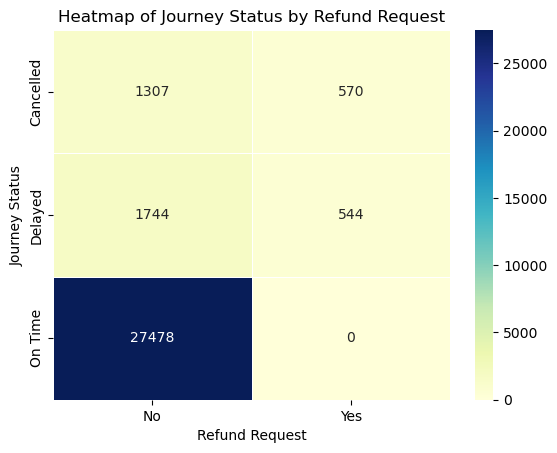

In [675]:
# plotting a heatmap for the cross table
sns.heatmap(crosstab_analysis, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Journey Status by Refund Request')
plt.xlabel('Refund Request')
plt.ylabel('Journey Status')
plt.show()

#### Line plot for median for each hour and the hour

In [693]:
# Line plot for median for each hour and the hour
df['Departure'] = pd.to_datetime(df['Departure'])
hourly_skewness = df.groupby(df['Departure'].dt.hour)['Price'].apply(lambda x: x.skew())
print(hourly_skewness)

Departure
0     1.699351
1     1.785441
2     3.533433
3     1.612692
4     2.483124
5     1.013008
6     2.603589
7     1.899100
8     0.766486
9     2.024152
10    3.154697
11    2.125580
12    2.926177
13    2.872804
14    2.150614
15    2.867104
16    2.580185
17    1.645339
18    3.609786
19    1.536854
20    2.641237
21    2.902843
22    1.036448
23    3.213839
Name: Price, dtype: float64


We can see from skewness, all of the hours had positive skewness, therefore, I will be using median as the estimator

<Axes: xlabel='Hour', ylabel='Price'>

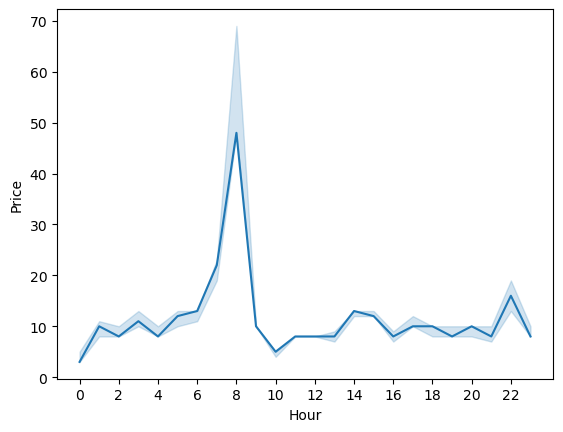

In [691]:
# plotting a line plot with median as estimator
df1['Departure'] = pd.to_datetime(df1['Departure'])
df1['Hour'] = df1['Departure'].dt.hour
plt.xticks(range(0,24,2))
sns.lineplot(x='Hour', y='Price', data=df1,estimator='median')


/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/2703435079.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stations_Disrupt.index, y=stations_Disrupt.values, palette='viridis')


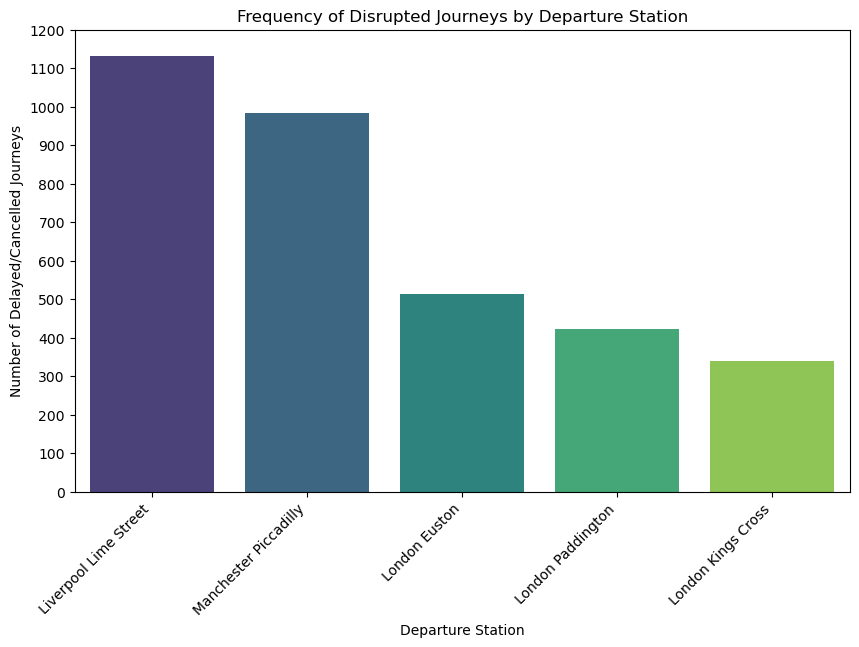

In [696]:
# Filter to Delayed
df_Disrupt = df1[ (df1['Journey.Status'] == 'Delayed') | (df1['Journey.Status'] == 'Cancelled') ]
# ONLY TOP 5
stations_Disrupt = df_Disrupt['Departure.Station'].value_counts().head(5)
# Plotting the frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=stations_Disrupt.index, y=stations_Disrupt.values, palette='viridis')
plt.title('Frequency of Disrupted Journeys by Departure Station')
plt.xlabel('Departure Station')
plt.ylabel('Number of Delayed/Cancelled Journeys')
plt.xticks(rotation=45, ha='right')  # Rotate station names for better readability
plt.yticks(np.arange(0, max(stations_Disrupt.values)+100, step=100))

plt.show()


#### Number of cancelled/delayed journeys depending on month 

/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/2397759025.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette=color_palette, ax=ax)
/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/2397759025.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette=color_palette, ax=ax)
/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/2397759025.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette=color_pa

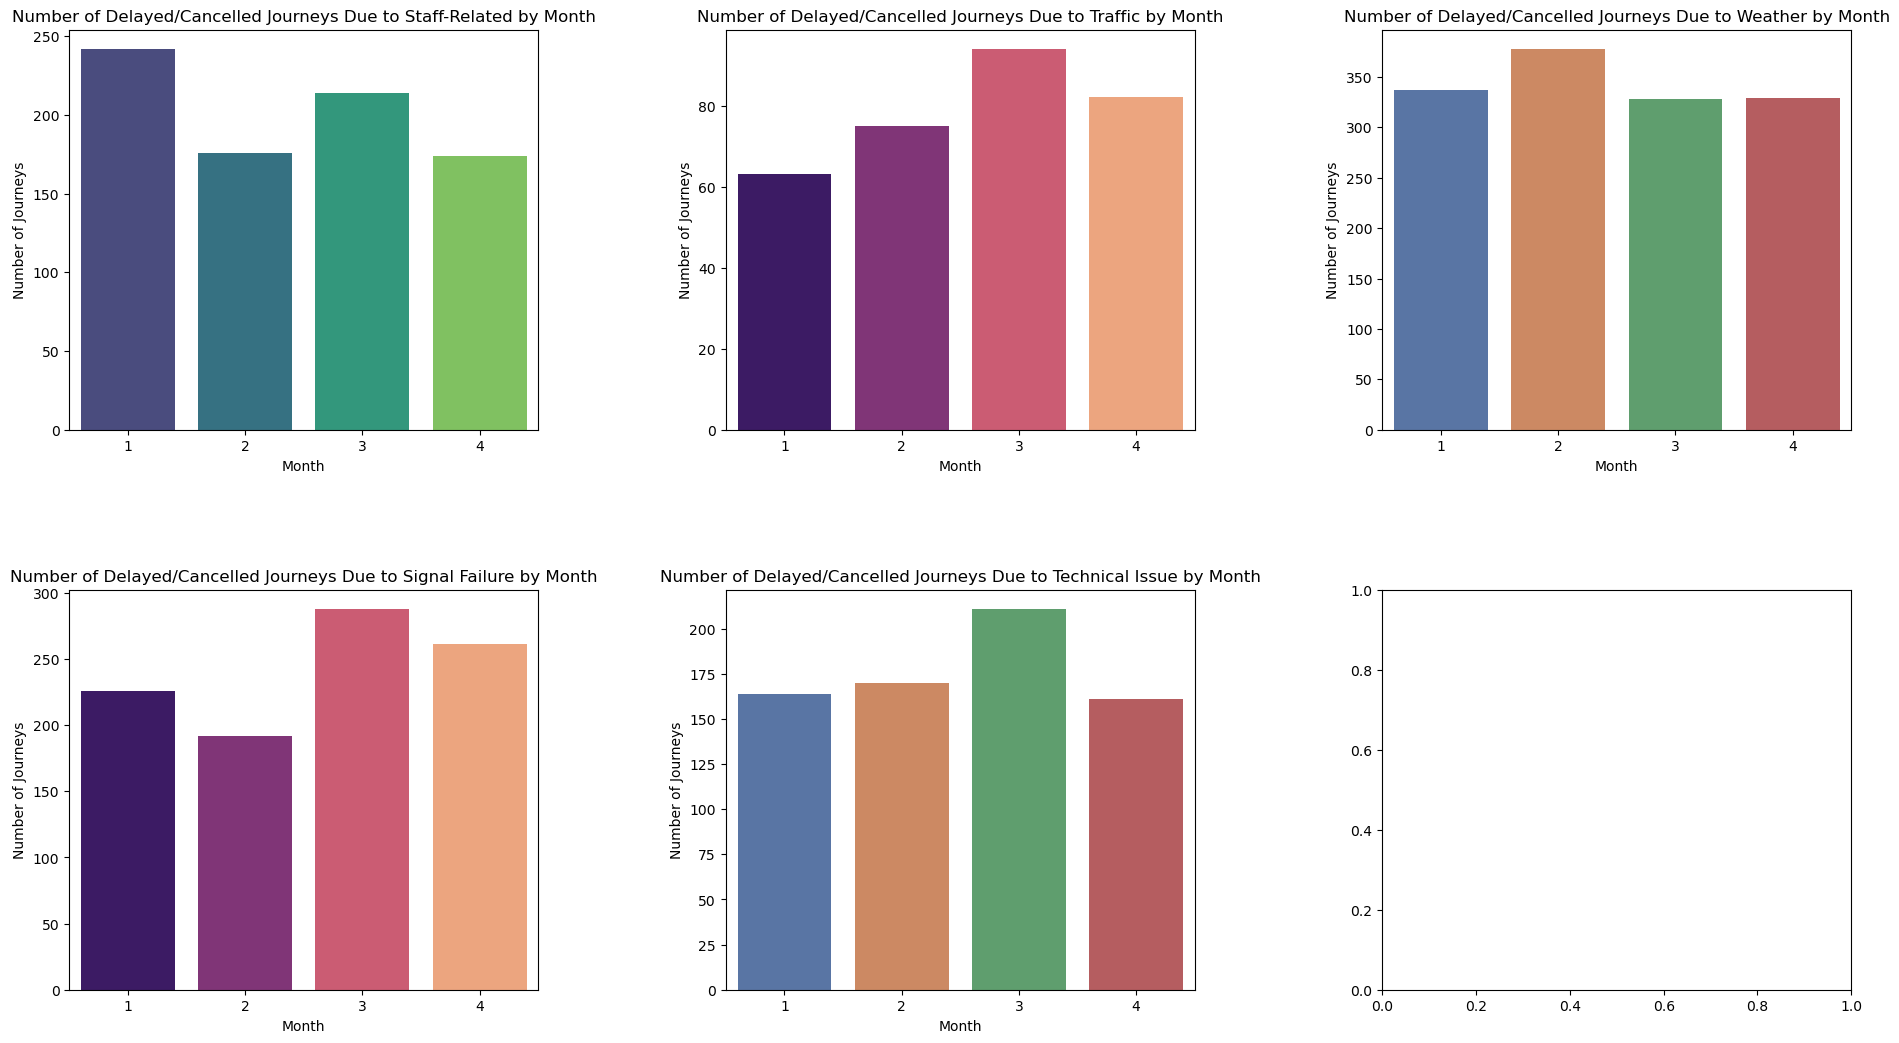

In [1113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# filter aand aggregate by reason and journey status
def filter_and_aggregate(df, reason, journey_status=['Delayed', 'Cancelled']):
    grouped = df.groupby([df['Departure'].dt.month, 'Journey.Status', 'Reason.for.Delay']).size()
    filtered = grouped.xs(reason, level='Reason.for.Delay')
    filtered = filtered[filtered.index.get_level_values('Journey.Status').isin(journey_status)]
    combined = filtered.groupby(level=0).sum()
    return combined

# plotting data
def plot_aggregated_data(ax, data, title, color_palette):
    sns.barplot(x=data.index, y=data.values, palette=color_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Journeys')

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 

axes = axes.flatten()

# Iterate over the reasons of delay and plot
for i, (reason, color, title) in enumerate([
    ('Staff-Related', 'viridis', 'Number of Delayed/Cancelled Journeys Due to Staff-Related by Month'),
    ('Traffic', 'magma', 'Number of Delayed/Cancelled Journeys Due to Traffic by Month'),
    ('Weather', 'deep', 'Number of Delayed/Cancelled Journeys Due to Weather by Month'),
    ('Signal Failure', 'magma', 'Number of Delayed/Cancelled Journeys Due to Signal Failure by Month'),
    ('Technical Issue', 'deep', 'Number of Delayed/Cancelled Journeys Due to Technical Issue by Month'),
]):
    aggregated_data = filter_and_aggregate(df1, reason)
    plot_aggregated_data(axes[i], aggregated_data, title, color)

plt.subplots_adjust(left=0.01, right=1, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()


Here, I am trying to see the frequency of distrupted journeys by months due to different reasons

#### PRICE AND REFUND

Refund.Request     No  Yes
Payment.Method            
Contactless     10622  210
Credit Card     18729  402
Debit Card       1178  502


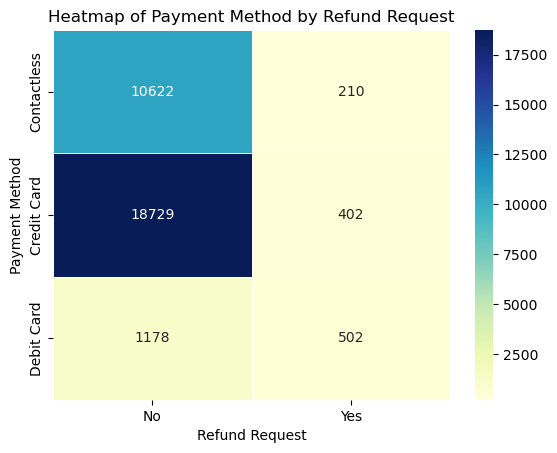

Payment.Method
Contactless    10.0
Credit Card    12.0
Debit Card     12.0
Name: Price, dtype: float64


In [701]:
df2 = pd.read_csv("MavenRailModified.csv")
# crosstab for payment method by refund request
crosstab_analysis2 = pd.crosstab(df1['Payment.Method'], df1['Refund.Request'])
print(crosstab_analysis2)
# plotting heatmap for the result
sns.heatmap(crosstab_analysis2, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Payment Method by Refund Request')
plt.xlabel('Refund Request')
plt.ylabel('Payment Method')
plt.show()
payments = df2.groupby('Payment.Method')['Price'].median()
print(payments)

GO ABOVE I EXPLAIN WHY I USED MEDIAN TO CHECK IF THEY HAVE SAME RANGE (CHECK FIGURES)

### 3) DelayInMinutes

In [ ]:
# I do actual arrival - scheduled arrival to get the delay time
df['Actual.Arrival'] = pd.to_datetime(df['Actual.Arrival'])
df.loc[df['Journey.Status'] == 'Delayed', 'DelayInMinutes'] = (df['Actual.Arrival'] - df['Scheduled.Arrival']).dt.total_seconds()/60
df.to_csv('MavenRailModified.csv',index=False)

### 4) MediumPrice

In [2143]:
fourth_df = df.loc[(df['Journey.Status'] == 'Delayed') | (df['Journey.Status'] == 'Cancelled')]

In [2145]:
# for logistic regression I need to make this class binary, 0 and 1s.
fourth_df['MediumPrice'] = fourth_df['Price'].apply(lambda x:1 if 10 < x <= 30 else 0)
fourth_df['Refund.Request'] = fourth_df['Refund.Request'].map({'Yes': 1, 'No': 0})

/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/1788234251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_df['MediumPrice'] = fourth_df['Price'].apply(lambda x:1 if 10 < x <= 30 else 0)
/var/folders/xq/mk_9dpc14877s8mzs6300hv80000gn/T/ipykernel_2291/1788234251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_df['Refund.Request'] = fourth_df['Refund.Request'].map({'Yes': 1, 'No': 0})


In [2147]:
fourth_df.to_csv("MavenRailMedium.csv",index=False)

In [2149]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2151]:
mediumDF = pd.read_csv("MavenRailMedium.csv")
# reshaping so that its in 2d
X = mediumDF['MediumPrice'].values.reshape(-1, 1)  
y = mediumDF['Refund.Request']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2153]:
# creating and training the model
model = LogisticRegression(random_state=42)
model.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [2155]:
#predicting the data
y_predict = model.predict(X_test)

In [2157]:
# classification report on the model
print("Accuracy:", model.score(X_test, y_test))
print(classification_report(y_predict,y_test))

Accuracy: 0.7322929171668667
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       833
           1       0.00      0.00      0.00         0

    accuracy                           0.73       833
   macro avg       0.50      0.37      0.42       833
weighted avg       1.00      0.73      0.85       833



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2159]:
# got intercept and coefficient variables.
intercept = model.intercept_
coefficient = model.coef_
print("intercept: ", intercept)
print("coefficient: ", coefficient)

intercept:  [-1.07555849]
coefficient:  [[0.35006662]]


In [2161]:
# probability of requesting refund given paid 5  (Question 4.I)
probabilities_5 = model.predict_proba([[0]])[0][1]
print(probabilities_5)

0.25434745194621616


In [2163]:
# probability of requesting refund given paid 25 (Question 4.II)
probabilities_25 = model.predict_proba([[1]])[0][1]
print(probabilities_25)

0.32618478540547996


#### Question 5: ToPredict.csv

I have 4 models for this section.
model is with under samping and my FINAL choice.

Chosen Featuers for combinations: [Price, Journey Status, Payment Method]

In [496]:
df5 = pd.read_csv('MavenRailMedium.csv')

Classification Report for features: ['Price', 'Payment.Method.Encoded']
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       610
           1       0.67      0.35      0.46       223

    accuracy                           0.78       833
   macro avg       0.73      0.64      0.66       833
weighted avg       0.76      0.78      0.75       833





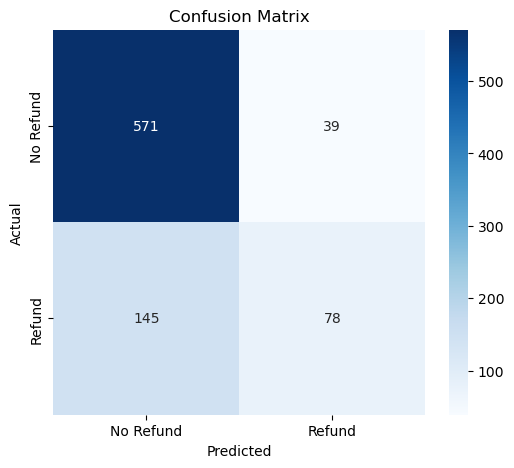

Classification Report for features: ['Price', 'Journey.Status.Encoded']
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       610
           1       0.00      0.00      0.00       223

    accuracy                           0.73       833
   macro avg       0.37      0.50      0.42       833
weighted avg       0.54      0.73      0.62       833





/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


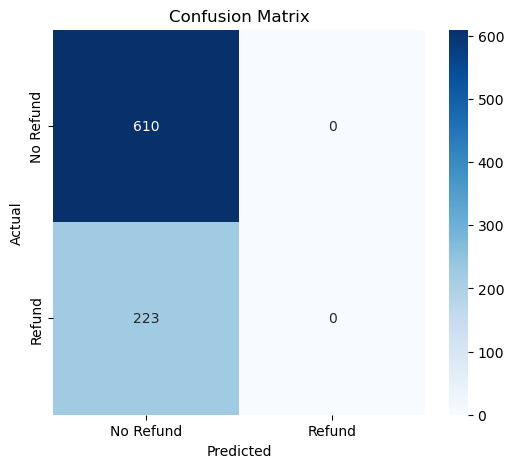

Classification Report for features: ['Payment.Method.Encoded', 'Journey.Status.Encoded']
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       610
           1       0.70      0.43      0.53       223

    accuracy                           0.80       833
   macro avg       0.76      0.68      0.70       833
weighted avg       0.78      0.80      0.78       833





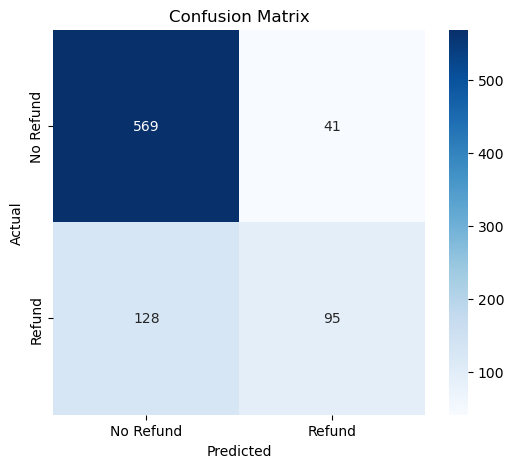

In [2244]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df5['Payment.Method.Encoded'] = encoder.fit_transform(df5['Payment.Method'])
df5['Journey.Status.Encoded'] = encoder.fit_transform(df5['Journey.Status'])
feature_combinations = [
    ['Price', 'Payment.Method.Encoded'],
    ['Price', 'Journey.Status.Encoded'],
    ['Payment.Method.Encoded', 'Journey.Status.Encoded']
]
X = df5[['Payment.Method.Encoded','Journey.Status.Encoded']]
y = df5['Refund.Request']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# evaluate the model over these combinations
for features in feature_combinations:
    X = df5[features]
    y = df5['Refund.Request']
    
    # splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit the model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    # Print classification report for evaluation
    print(f"Classification Report for features: {features}")
    print(classification_report(y_test, y_pred))
    print("\n")
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Refund', 'Refund'], yticklabels=['No Refund', 'Refund'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



#### Question 5 Final solution:

In [2085]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset
df10 = pd.read_csv("MavenRail.csv")

# encoding the chosen features
encoder = LabelEncoder()
df10['Payment.Method.Encoded'] = encoder.fit_transform(df10['Payment.Method'])
df10['Journey.Status.Encoded'] = encoder.fit_transform(df10['Journey.Status'])


X = df10[['Payment.Method.Encoded','Journey.Status.Encoded']]
y = df10['Refund.Request']
# print classes before undersampling
print(f"Class distribution before undersampling:\n{y.value_counts()}")

# Undersample the majority class
undersampler = RandomUnderSampler(sampling_strategy='auto',random_state=42)
X_balanced, y_balanced = undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, 
                                                    test_size=0.2, random_state=42)

# Print classes after undersampling
print(f"Class distribution after undersampling:\n{y_train.value_counts()}")

# initialize and train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Coefficients of features, [Payment.Method, Journey.Status]")
print(model.coef_)

Class distribution before undersampling:
Refund.Request
No     30531
Yes     1114
Name: count, dtype: int64
Class distribution after undersampling:
Refund.Request
Yes    901
No     881
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

          No       0.98      0.88      0.93       233
         Yes       0.88      0.98      0.93       213

    accuracy                           0.93       446
   macro avg       0.93      0.93      0.93       446
weighted avg       0.93      0.93      0.93       446

Coefficients of features, [Payment.Method, Journey.Status]
[[ 2.17610914 -3.88320004]]


Length of y_test: 446
Length of y_pred: 446


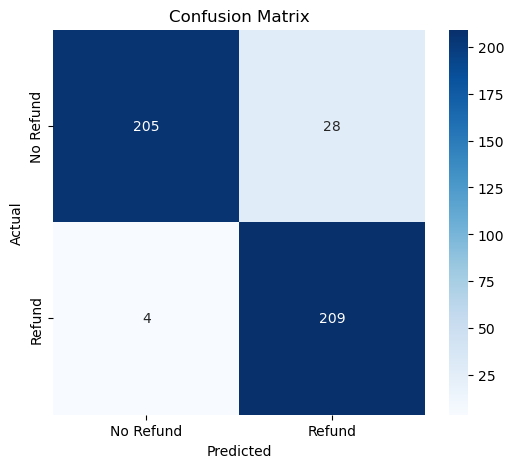

In [2087]:
# Check that y_test and y_pred have the same length
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred: {len(y_pred)}")

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Refund', 'Refund'], yticklabels=['No Refund', 'Refund'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Testing the model built on ToPredict dataset

In [2217]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Load the new data for prediction
predictdf = pd.read_csv("ToPredict(1).csv")

# encoding the chosen features
encoder = LabelEncoder()

predictdf['Payment.Method.Encoded'] = encoder.fit_transform(predictdf['Payment.Method'])
predictdf['Journey.Status.Encoded'] = encoder.fit_transform(predictdf['Journey.Status'])

X_predict = predictdf[['Payment.Method.Encoded','Journey.Status.Encoded']]

In [2221]:
y_prob = model.predict_proba(X_predict)
# we do [:,1] to extract the probabilities for YES (1) refund request
predictdf['Predicted.Refund.Probability'] = y_prob[:,1]
# we predict the classification of the classes
predictdf['Predicted.Refund.Request'] = model.predict(X_predict)
# for visualisation purposes
print(predictdf[[ 'Predicted.Refund.Request','Predicted.Refund.Probability']])

  Predicted.Refund.Request  Predicted.Refund.Probability
0                       No                      0.189659
1                       No                      0.023459
2                      Yes                      0.929910
3                       No                      0.122628
4                      Yes                      0.987211
5                      Yes                      0.887930
6                      Yes                      0.929910
7                      Yes                      0.987211
